In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import SyntheticDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import SyntheticDataset, SyntheticDatasetType
dataset_type = SyntheticDatasetType.SNR40
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData')
dataset = SyntheticDataset(config.Synthetic_PATH, type=dataset_type ,transform=None)

In [3]:
def preprocessing(X:np.ndarray):
        '''
            Preprocessing the dataset for removing high-frequency noise. 
            This preprocessing consists of three steps:
                1. Median filter in the spatial domain.
                2. Moving average filter in the spectral domain. (No!)
                3. Normalization of the data.

            Parameters
            ----------
                X : np.ndarray, shape (nRow, nCol, nBand)
                    HSI Cube.
        '''
        from skimage.filters import median
        from utils import moving_average

        X = median(X, footprint=np.ones((3,3,1)))
        # X = moving_average(X.reshape(-1, X.shape[-1]), 5, padding_size=4).reshape(X.shape[0], X.shape[1], -1)
        return X

X_filtered = preprocessing(dataset.X.reshape(dataset.n_row, dataset.n_col, -1))
dataset.X = torch.tensor(X_filtered.reshape(-1, X_filtered.shape[-1])).float()

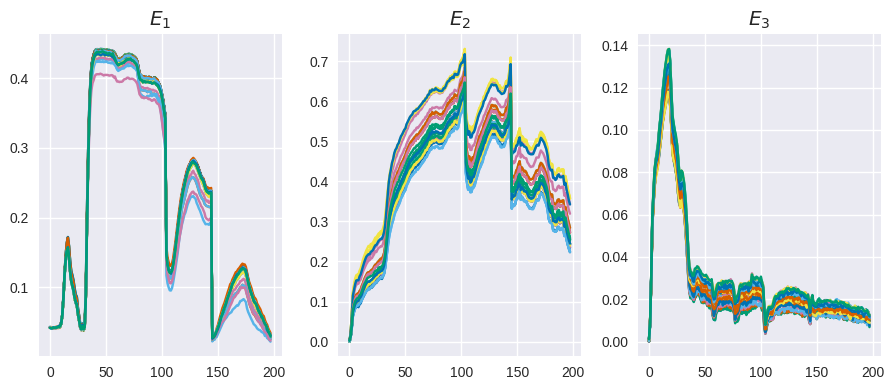

In [4]:
gt = torch.tensor(dataset.abundance()).permute(2,0,1)

#pick up the 32 first samples with the highest abundance per endmember
test_idx = torch.zeros(dataset.n_endmembers, 32, dtype=torch.long)
for i in range(dataset.n_endmembers):
    _, test_idx[i,:] = torch.topk(gt[i,:,:].flatten(), 32)

# sepparate train samples and test samples
train_idx = torch.ones_like(gt[0,:,:].flatten(), dtype=torch.bool)
train_idx[test_idx] = False
train_idx = torch.where(train_idx)[0]

# plot it
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(dataset.n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(dataset[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()

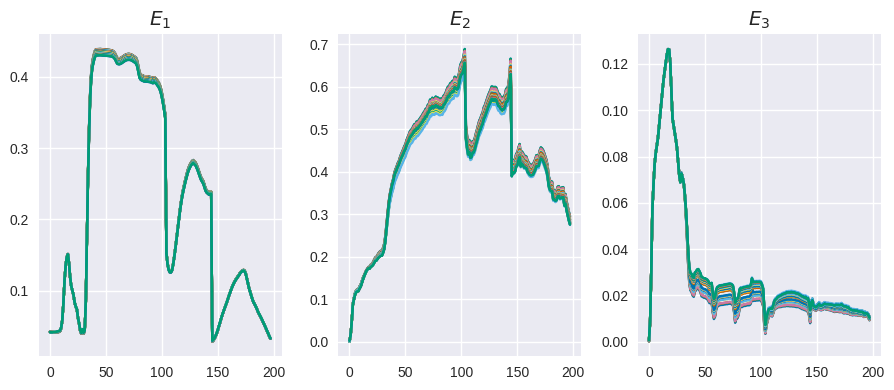

In [5]:
estimated_gt = dataset.A @ dataset.endmembers()

with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(dataset.n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(estimated_gt[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()



In [6]:
# create a subset of the dataset
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx.flatten())
# estimated_gt_test = estimated_gt[test_idx.flatten()]
# test_dataset = torch.utils.data.TensorDataset(estimated_gt_test)

# CLHU Model

In [19]:
def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

In [20]:
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from HySpecLab.unmixing.mixture import lmm
from HySpecLab.unmixing.utils import slide

from IPDL import MatrixEstimator
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis


import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(encode_layers[-1], n_bands, bias=False),
            MatrixEstimator(.1)
        )
        
        # Abundance matrix
        self.A = None
        self.A_matrix_estimator = MatrixEstimator(.1)
        self.matrix_estimator = MatrixEstimator(.1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r0 = self.projection( self.encoder(input) )

        self.A = self.A_matrix_estimator(self.__similarity(r0))
        out = lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))
        return self.matrix_estimator(out)
        # return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            MatrixEstimator(.1),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()],
        )

    def __similarity(self, X: torch.Tensor, temperature=1e-1) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        return (1 - torch.pow(cos, 2))/temperature
    
    def mi_ze(self, gamma=1e-2):
        '''
            Compute the mutual information between the latent space and the endmembers.
            I(Z;E) = H(Z) - H(Z|E)
        '''
        z_p = self.projection[-1].x.to(self.ebk.device)
        z = self.encoder[-1][-2].x.cpu()
        # z = self.encoder[-1][-1].x.cpu()
        Hz = renyis.entropy(define_Ax(z, gamma))
        # Hz = renyis.entropy(self.encoder[-1][-2].get_matrix())
        
        A = self.__similarity(z_p, temperature=1).detach().cpu()
        # A = softmax(self.__similarity(z_p).detach().cpu(), dim=1)
        HA = renyis.entropy(define_Ax(A, gamma))

        return Hz - HA


In [21]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from tqdm import tqdm
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader
from IPDL import ClassificationInformationPlane, AutoEncoderInformationPlane
from IPDL.optim import SilvermanOptimizer

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from tqdm import tqdm
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, train_dataset:Dataset, test_dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(train_dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))


    dataloader = DataLoader(train_dataset, batch_size=int(len(train_dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 0
    simplex_weight = 5e-3
    similarity_weight = .1

    scaler = torch.cuda.amp.GradScaler()

    gamma = 1e-2
    #IPDL
    matrix_optimizer = SilvermanOptimizer(model, gamma=gamma, normalize_dim=True)
    ip = AutoEncoderInformationPlane(model)
    # ip = ClassificationInformationPlane(model, use_softmax=False)
    Ax = define_Ax(test_dataset[:], gamma=gamma)
    
    gt_abundance = test_dataset.dataset.A[test_dataset.indices]
    gt_endmember = test_dataset.dataset.E
    gt = gt_abundance @ gt_endmember
    Agt = define_Ax(gt, gamma=gamma)

    Ize = np.zeros(n_epochs+1)
    with torch.no_grad():
        model.eval()
        x = test_dataset[:].to(device)
        y = model(x)
        Ize[0] = model.mi_ze(gamma=gamma)

    for epoch in epoch_iterator:
        epoch_loss = 0.
        model.train()
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        with torch.no_grad():
            model.eval()
            x = test_dataset[:].to(device)
            y = model(x)
            test_loss = criterion(y, x)
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)), vls="%.4f" % test_loss.item())

        if epoch == 0: # Solo necesario una vez
            matrix_optimizer.step()

        _, _ = ip.computeMutualInformation(Ax.to(device))
        # _, _ = ip.computeMutualInformation(Ax.to(device), Agt.to(device))
        Ize[epoch+1] = model.mi_ze(gamma=1e-2)

    return ip, Ize

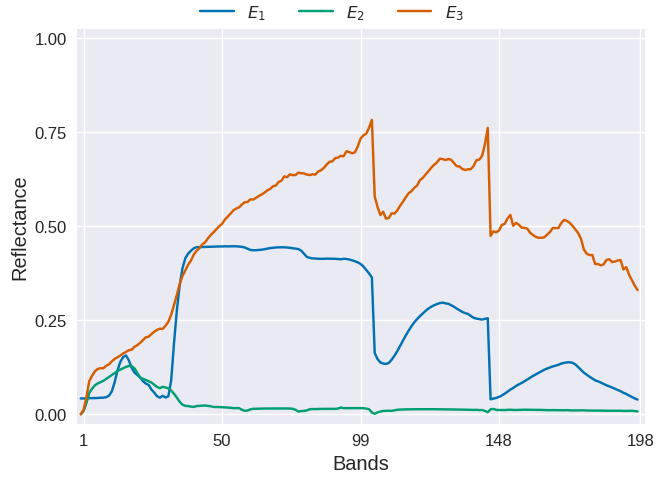

In [22]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=42)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .8

logit_endmember_init = torch.log((endmember_init + 1e-12) / ((1-endmember_init) + 1e-12))
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))
    

fig = plot_endmembers(endmember_init)
plt.show()


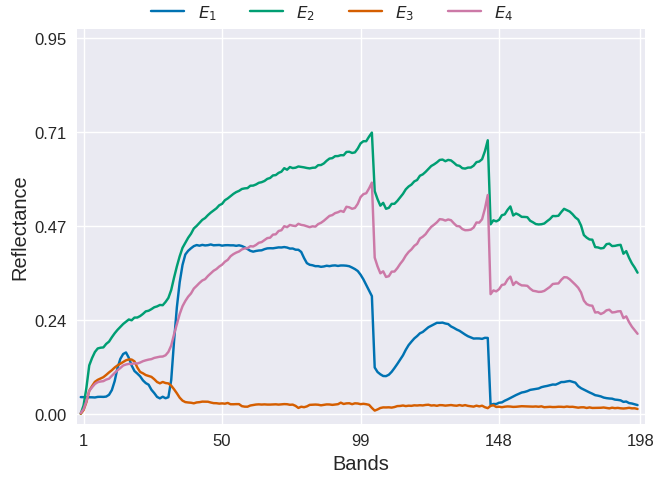

In [23]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers + 1

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

endmember_init = endmember.float()
logit_endmember_init = torch.log((endmember_init + 1e-12) / ((1-endmember_init) + 1e-12))
# nfindr_endmember_init, _, _ = sort_endmember(endmember, dataset.endmembers())
# nfindr_logit_endmember_init = torch.log((nfindr_endmember_init / (1-nfindr_endmember_init) + 1e-12))

# apply soft noise to endmember
# endmember_init = torch.abs(endmember_init + torch.randn_like(endmember_init) * .005)
# logit_endmember_init = torch.log((endmember_init + 1e-12) / ((1-endmember_init) + 1e-12))

fig = plot_endmembers(endmember_init, ticks_range=(0, .95))
plt.show(fig)

In [24]:
model = ContrastiveUnmixing(dataset.n_bands, n_endmembers, encode_layers=[512, 64], endmember_init=logit_endmember_init)
ip, Ize = train(model, n_endmembers, train_dataset, test_dataset, n_batchs=50, n_epochs=50, lr=1e-3)

100%|██████████| 50/50 [00:28<00:00,  1.75epoch/s, tls=0.0565, vls=0.0813]


In [25]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

_X = test_dataset[:] 

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), 2*volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0813) tensor(0.4434) tensor(0.0350) tensor(0.4389)


In [26]:
volume_reg(endmember_init)*2, similarity_reg(endmember_init)

(tensor(6.5863), tensor(0.5285))

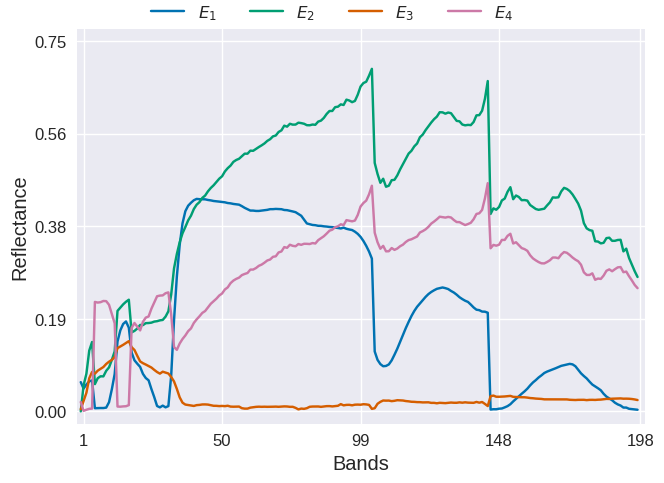

In [27]:
ebk = sigmoid(model.ebk.detach().cpu())
fig = plot_endmembers(ebk, ticks_range=(0, .75))
plt.show()

# fig.savefig(os.path.join(result_path, 'informationTheory/imgs/M_clhu_{}end.pdf'.format(n_endmembers)), bbox_inches='tight')


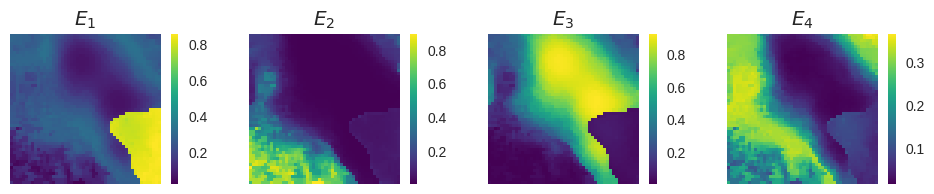

In [28]:
from torch.nn.functional import softmax
_ = model(dataset.X)

test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

# fig.savefig(os.path.join(result_path, 'informationTheory/imgs/A_clhu_{}end.pdf'.format(n_endmembers)), bbox_inches='tight')


# IP

In [29]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
def moving_average(a, n=10, padding_size=0) :
    ret = np.cumsum(a, dtype=float) if padding_size == 0 else np.cumsum(np.insert(a, 0, np.zeros(padding_size)), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def show_ip(ip_df: pd.DataFrame, n=25, labels=[], moving_average_n=25):
    '''
        Create a Information Plane illustration

        Parameters
        ----------
        ip_df : pd.Dataframe, dataframe which contains the MI. This dataframe
            has a specific structure which is created from IPDL.InformationPlane class
        n: int, Number of samples to visualize, sampling generated by a log-scale
    '''
    colors = ['Greys', 'Reds', 'Blues', 'Greens', 'Oranges',
                'Purples', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd',
                'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn',
                'BuGn', 'YlGn']

    with plt.style.context('seaborn'):
        fig = plt.figure(figsize=(6, 4),constrained_layout=False)
        gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.84, wspace=0.05)
        gs2 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=0.85, right=0.95, wspace=0)
        f8_ax1 = fig.add_subplot(gs1[:, :])
        f8_ax1.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
        f8_ax1.set_ylabel("$\mathcal{I}(T; Y)$", fontsize=14)

        for idx, (layer, _) in enumerate(ip_df.columns[::2]):
            Ity = moving_average(ip_df[layer]['Ity'].to_numpy(), n=moving_average_n, padding_size=int(moving_average_n*0.3))
            Ixt = moving_average(ip_df[layer]['Ixt'].to_numpy(), n=moving_average_n, padding_size=int(moving_average_n*0.3))
            
            cmap = cm[colors[idx]]
            iterations = np.geomspace(1, len(Ity)-1, num=n, dtype=np.uint)

            color = np.array([cmap(iterations[int(len(iterations)*0.95)])])
            sc = f8_ax1.scatter(Ixt[iterations], Ity[iterations], c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
            if not labels:
                f8_ax1.scatter([], [], c=color, label=layer)
            else:
                f8_ax1.scatter([], [], c=color, label=labels[idx])

            f8_ax2 = fig.add_subplot(gs2[0, idx])
            cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
            cb.set_ticks([])

        f8_ax1.legend()
        cb.set_ticks([0, iterations.max()])
        f8_ax2.set_yticklabels(['0', ip_df[layer]['Ixt'].size - 1])
        cb.set_label("Iterations", labelpad=-18)

    return fig

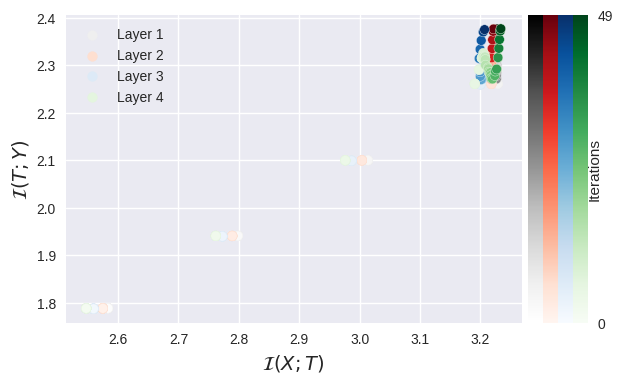

In [30]:
df = ip.to_df()

fig = show_ip(df, n=50, moving_average_n=15)
plt.show(fig)

(4, 50)
(4, 50)


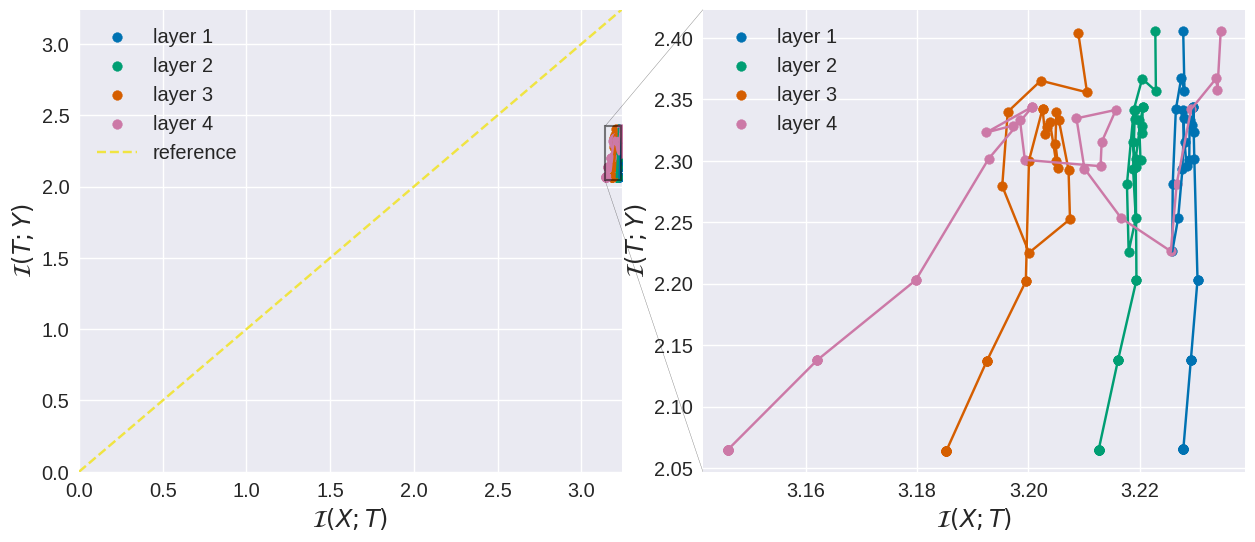

In [31]:
from IPDL import MatrixBasedRenyisEntropy

def moving_average_2(a:np.ndarray, n=3, padding_size=2):
    ''' 
        Moving average filter for 1-D array.
        Parameters
        ----------
        a : 1-D array, shape (batch_size, n_features)
            Input array.
        n : int, optional
            Window size. Default is 3.
        padding_size : int, optional
            Padding size. Default is 2.
    
    '''
    if padding_size > 0:
        a = np.pad(a, ((0,0), (padding_size//2, padding_size//2)), 'edge')

    ret = np.cumsum(a, axis=1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

Ax = define_Ax(test_dataset[:], gamma=1e-2)
# Ax = define_Ax(test_dataset[:][0], gamma=1e-3)

with plt.style.context('seaborn-colorblind'):
    fig, ax = plt.subplots(figsize=(7, 6))
    reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()
    ax.set(xlim=(0, reference), ylim=(0, reference))
    axins = ax.inset_axes([1.15, 0., 1, 1])

    Ixt, Ity = ip.getMutualInformation(moving_average_n=1)
    print(np.array(Ixt).shape)
    Ixt = moving_average_2(np.array(Ixt), n=5, padding_size=4)
    Ity = moving_average_2(np.array(Ity), n=5, padding_size=4)
    print(Ixt.shape)

    iterations = np.geomspace(1, len(Ixt[0])-1, 30, dtype=np.uint)
    for idx, current_Ixt in enumerate(Ixt[:]):
        current_Ity = Ity[idx]
        ax.scatter(current_Ixt[iterations], current_Ity[iterations], label="layer {}".format(idx+1))
        ax.plot(current_Ixt[iterations], current_Ity[iterations])

        axins.scatter(current_Ixt[iterations], current_Ity[iterations], label="layer {}".format(idx+1))
        axins.plot(current_Ixt[iterations], current_Ity[iterations])

    ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=1.5)
 
ax.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
ax.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')

axins.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
axins.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')
axins.legend(fontsize='x-large')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', label='reference')
ax.legend(fontsize='x-large')

#ticks bigger
ax.tick_params(axis='both', which='major', labelsize='x-large')
axins.tick_params(axis='both', which='major', labelsize='x-large')

plt.show()

In [229]:
ip.to_df()

Layer 1             Layer 2             Layer 3             Layer 4  \
         Ixt       Ity       Ixt       Ity       Ixt       Ity       Ixt   
0   3.223326  1.790009  3.201744  1.789648  3.158886  1.788740  3.028137   
1   3.228858  2.058532  3.210562  2.058421  3.180254  2.058084  3.094095   
2   3.229311  1.991801  3.208397  1.991636  3.178686  1.991303  3.096895   
3   3.229702  2.050855  3.209746  2.050611  3.180213  2.049940  3.111997   
4   3.228489  1.995223  3.209687  1.995053  3.182812  1.994554  3.160850   
5   3.229977  1.985647  3.213686  1.985546  3.188913  1.985271  3.154439   
6   3.230654  2.113758  3.214697  2.113352  3.193837  2.112588  3.155284   
7   3.230513  2.180855  3.213763  2.180479  3.195682  2.179965  3.156659   
8   3.229959  2.118659  3.213947  2.118306  3.193990  2.117703  3.173426   
9   3.228746  2.190810  3.211333  2.190427  3.190637  2.189681  3.179036   
10  3.229133  2.249094  3.215527  2.248941  3.197350  2.248449  3.192773   
11  3.227810  1.866660  3.213956  1.866331  3.193339  1.865647  3.187413   
12  3.226655  2.107065  3.210817  2.106990  3.192939  2.106662  3.203029   
13  3.228881  2.106167  3.214620  2.105913  3.197831  2.105480  3.199440   
14  3.228352  2.030527  3.209842  2.030321  3.190551  2.029889  3.196568   
15  3.227878  2.168707  3.208862  2.168417  3.187027  2.167616  3.203359   
16  3.227174  2.230180  3.207034  2.229817  3.186346  2.228970  3.210777   
17  3.228765  1.866032  3.208184  1.865841  3.189755  1.865458  3.201830   
18  3.226348  2.175968  3.203647  2.175649  3.181767  2.174961  3.195607   
19  3.228218  2.237229  3.207647  2.236741  3.186455  2.235934  3.203094   
20  3.227413  2.245853  3.206171  2.245361  3.189261  2.244609  3.213647   
21  3.227532  2.067499  3.208708  2.067318  3.193676  2.066914  3.217124   
22  3.229199  2.088341  3.208039  2.087721  3.191823  2.086941  3.200257   
23  3.228659  2.073216  3.206071  2.072828  3.191590  2.072377  3.194689   
24  3.227598  2.293805  3.204271  2.293387  3.193136  2.293029  3.198536   
25  3.229859  2.161158  3.212349  2.160839  3.202503  2.160455  3.205393   
26  3.226982  2.289352  3.207283  2.288854  3.198151  2.288569  3.208886   
27  3.227324  2.333949  3.205611  2.333387  3.196603  2.333039  3.194239   
28  3.229869  2.180693  3.213414  2.180314  3.203966  2.179894  3.212154   
29  3.229428  2.147734  3.211668  2.147319  3.202788  2.146889  3.195959   
30  3.228058  2.402217  3.210951  2.401909  3.203517  2.401555  3.213701   
31  3.230268  2.136799  3.215251  2.136396  3.207161  2.135988  3.200591   
32  3.228167  2.353641  3.214636  2.353289  3.206966  2.352920  3.212521   
33  3.229625  2.318213  3.217935  2.317759  3.209807  2.317319  3.205765   
34  3.227551  2.354815  3.218575  2.354309  3.209189  2.353927  3.219815   
35  3.228770  2.354792  3.216245  2.354351  3.208382  2.353765  3.207846   
36  3.227489  2.452725  3.213864  2.452175  3.203308  2.451487  3.208029   
37  3.227870  2.446310  3.215115  2.445884  3.205634  2.445321  3.214880   
38  3.228553  2.315387  3.215635  2.314909  3.206732  2.314240  3.209617   
39  3.229198  2.401120  3.217021  2.400602  3.207567  2.399793  3.204596   
40  3.227561  2.448183  3.214770  2.447621  3.205804  2.447009  3.215767   
41  3.229062  2.421555  3.216805  2.420959  3.207869  2.420297  3.208418   
42  3.229649  2.415845  3.218638  2.415420  3.210467  2.414841  3.209739   
43  3.228175  2.440977  3.216081  2.440453  3.208393  2.439767  3.219680   
44  3.230211  2.393835  3.219997  2.393180  3.212108  2.392321  3.205092   
45  3.228238  2.365819  3.212933  2.364968  3.204401  2.364147  3.199475   
46  3.228202  2.387040  3.213482  2.386182  3.205791  2.385538  3.215243   
47  3.228681  2.346190  3.216249  2.345469  3.208704  2.344882  3.217398   
48  3.227801  2.472659  3.215434  2.471952  3.209684  2.471666  3.220778   
49  3.229119  2.447275  3.217273  2.446562  3.212288  2.446105  3.211423   

              
         Ity  
0   1.789408  
1   2.0

In [230]:
df = ip.to_df()
df.to_csv(os.path.join(result_path, 'informationTheory/ip_{}end.csv'.format(n_endmembers)), index=False)
df.to_pickle(os.path.join(result_path, 'informationTheory/ip_{}end.pkl'.format(n_endmembers)))

In [231]:
# Ize to dataframe
df = pd.DataFrame(Ize, columns=['Ize'])
df.to_csv(os.path.join(result_path, 'informationTheory/Ize_{}end.csv'.format(n_endmembers)), index=False)

In [233]:
Ize

array([1.17978323, 2.8465054 , 2.56772661, 2.52969384, 2.64479399,
       2.48815155, 2.57847834, 2.45772839, 2.6248517 , 2.3255949 ,
       2.37893009, 2.16510201, 2.37214756, 2.17615461, 2.24355698,
       2.45274758, 2.22504354, 2.15969682, 2.26697206, 2.1600318 ,
       2.19145751, 2.04584742, 1.96882582, 2.199265  , 2.23278356,
       1.99447489, 2.16466713, 1.92272305, 1.90494704, 2.0686264 ,
       2.15263081, 1.90337253, 2.09633541, 1.94370461, 1.94264698,
       1.6899848 , 1.93263531, 1.82593441, 1.79981518, 1.84816504,
       1.86218643, 1.73355198, 1.91713834, 1.92901945, 1.81430745,
       1.95191169, 1.96543789, 1.85445356, 1.82657647, 1.72827005,
       1.87596512])

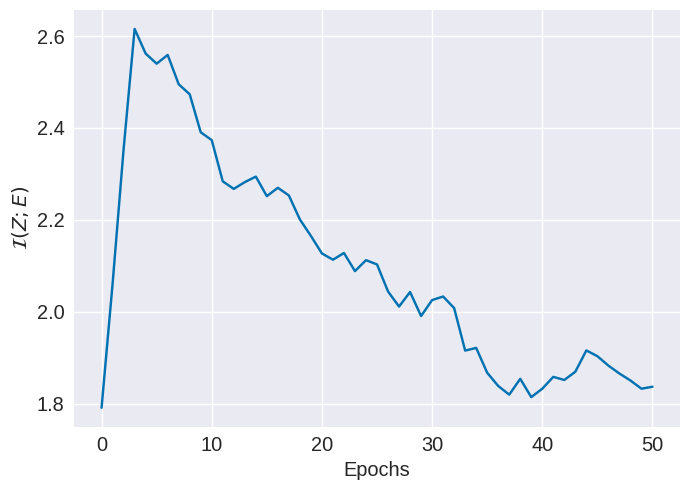

In [232]:
from utils import moving_average

Ize_average = moving_average(Ize.reshape(1,-1), n=5, padding_size=4) 
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(Ize_average.T)
    plt.xlabel('Epochs', fontsize='x-large')
    plt.ylabel('$\mathcal{I}(Z;E)$', fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()

In [258]:
from IPDL import MatrixBasedRenyisEntropy as renyis
estimated_gt_test = estimated_gt[test_idx.flatten()]
Agt = define_Ax(estimated_gt_test[:], gamma=1e-2)
renyis.entropy(Agt)

tensor(2.2058)

In [259]:
reconstruct = model(test_dataset[:])
A = define_Ax(reconstruct.detach().cpu(), gamma=1e-2)
renyis.entropy(A)

NameError: name 'model' is not defined

# Images

In [77]:
def moving_average(a:np.ndarray, n=3, padding_size=2):
    ''' 
        Moving average filter for 1-D array.
        Parameters
        ----------
        a : 1-D array, shape (batch_size, n_features)
            Input array.
        n : int, optional
            Window size. Default is 3.
        padding_size : int, optional
            Padding size. Default is 2.
    
    '''
    if padding_size > 0:
        a = np.pad(a, ((0,0), (padding_size//2, padding_size//2)), 'edge')

    ret = np.cumsum(a, axis=1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

## 3 endmembers

In [78]:
import pandas as pd
n_endmembers = 3
ip_df = pd.read_pickle(os.path.join(result_path, 'informationTheory/ip_{}end.pkl'.format(n_endmembers)))

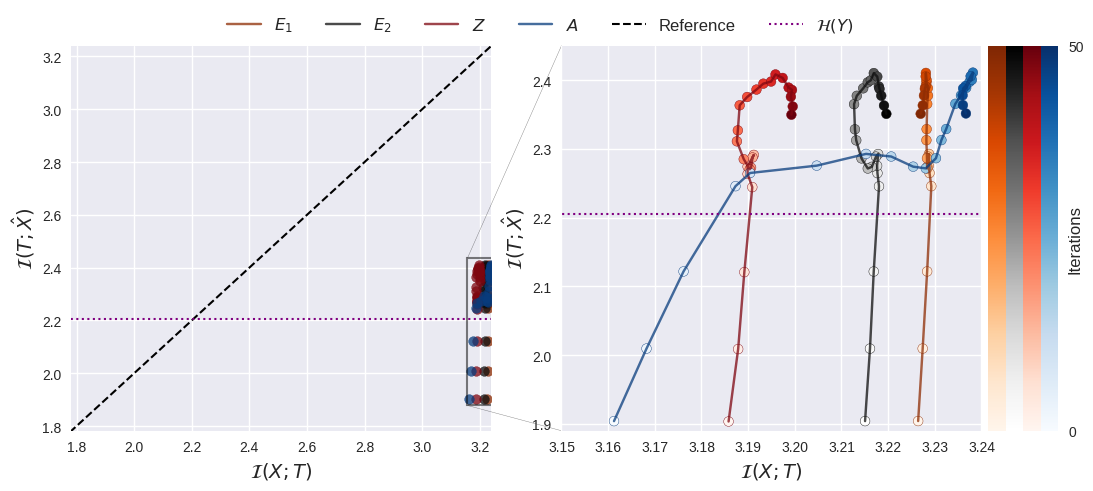

In [79]:
n_layers = ip_df.columns[::2].size
n_epochs = len(ip_df)
n_iterations = 25
labels = ['$E_1$', '$E_2$', '$Z$', "$A$"]
iterations = np.linspace(0, n_epochs-1, n_iterations, dtype=np.uint)


colors = [  'Oranges', 'Greys', 'Reds', 'Blues', 'Greens',
            'Purples', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd',
            'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn',
            'BuGn', 'YlGn'  ]

fig = plt.figure(figsize=(7, 5),constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.68, wspace=0.05)
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.78, right=1.38, wspace=0)
gs3 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=1.39, right=1.49, wspace=0)

ax = fig.add_subplot(gs1[:, :])
ax.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
ax.set_ylabel("$\mathcal{I}(T; \hat{X})$", fontsize=14)
ax.set(xlim=(reference-(reference*.45), reference), ylim=(reference-(reference*.45), reference))

axins = fig.add_subplot(gs2[:, :])
axins.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
axins.set_ylabel("$\mathcal{I}(T; \hat{X})$", fontsize=14)

for i in range(n_layers):
    Ixt = ip_df[ip_df.columns[2*i]].to_numpy().reshape(1, -1)
    Ity = ip_df[ip_df.columns[2*i + 1]].to_numpy().reshape(1, -1)

    Ixt = moving_average(Ixt, n=11, padding_size=10).reshape(-1)
    Ity = moving_average(Ity, n=11, padding_size=10).reshape(-1)

    cmap = cm[colors[i]]

    # obtaain color with the largest constrast
    norm = matplotlib.colors.Normalize(vmin=0, vmax=n_iterations)
    color = cmap(norm(n_iterations*.95))
    ax.scatter(Ixt[iterations], Ity[iterations], color=color, alpha=.75)

    sc = axins.scatter(Ixt[iterations], Ity[iterations], c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
    axins.plot(Ixt[iterations], Ity[iterations], color=color, alpha=.75, label=labels[i])

    f8_ax2 = fig.add_subplot(gs3[0, i])
    cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
    cb.set_ticks([])

entropy_reference = 2.2058
ax.plot([0, reference], [0, reference], color='black', linestyle='--', linewidth=1.5, label='Reference')
ax.plot([0, reference], [entropy_reference, entropy_reference], color='purple', linestyle=':', linewidth=1.5, label='$\mathcal{H}(Y)$')
ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=1.5)

# plot a line with the entropy of the reference without changes the ticks in x
_x_ticks = axins.get_xticks()
_y_ticks = axins.get_yticks()
axins.plot([0, reference], [0, reference], color='black', linestyle='--', linewidth=1.5, label='Reference')
axins.plot([0, reference], [entropy_reference, entropy_reference], color='purple', linestyle=':', linewidth=1.5, label='$\mathcal{H}(Y)$')
axins.set_xticks(_x_ticks[0:-1])
axins.set_xlim(_x_ticks[0], _x_ticks[-2])
axins.set_yticks(_y_ticks[:])
axins.set_ylim(_y_ticks[1]-1e-2, _y_ticks[-2]+5e-2)




handles, labels = axins.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=10, fontsize='large', bbox_to_anchor=(.75, 0.97))

cb.set_ticks([0, iterations.max()])
f8_ax2.set_yticklabels(['0', n_epochs])
cb.set_label("Iterations", labelpad=-12, fontsize='large')

plt.show()

fig.savefig('ip_end3.pdf', bbox_inches='tight')

## 4 endmembers

In [80]:
n_endmembers = 4
ip_df = pd.read_pickle(os.path.join(result_path, 'informationTheory/ip_{}end.pkl'.format(n_endmembers)))

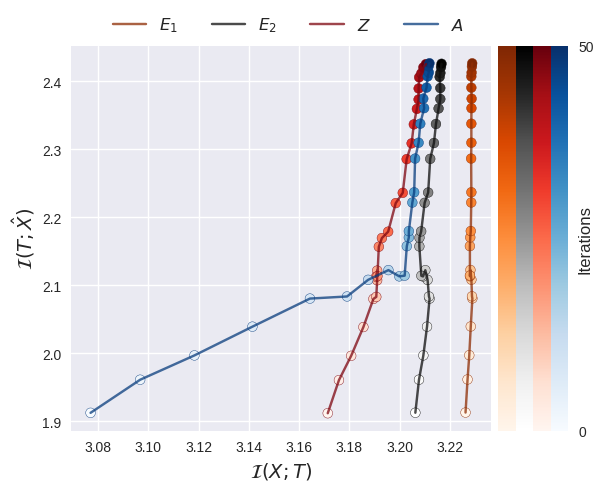

In [81]:
n_layers = ip_df.columns[::2].size
n_epochs = len(ip_df)
n_iterations = 25
labels = ['$E_1$', '$E_2$', '$Z$', "$A$"]
iterations = np.linspace(0, n_epochs-1, n_iterations, dtype=np.uint)


colors = [  'Oranges', 'Greys', 'Reds', 'Blues', 'Greens',
            'Purples', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd',
            'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn',
            'BuGn', 'YlGn'  ]

fig = plt.figure(figsize=(7, 5),constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.68, wspace=0.05)
gs2 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=.69, right=.79, wspace=0)
# gs3 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=1.39, right=1.49, wspace=0)

ax = fig.add_subplot(gs1[:, :])
ax.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
ax.set_ylabel("$\mathcal{I}(T; \hat{X})$", fontsize=14)
# ax.set(xlim=(reference-(reference*.45), reference), ylim=(reference-(reference*.45), reference))

for i in range(n_layers):
    Ixt = ip_df[ip_df.columns[2*i]].to_numpy().reshape(1, -1)
    Ity = ip_df[ip_df.columns[2*i + 1]].to_numpy().reshape(1, -1)

    Ixt = moving_average(Ixt, n=15, padding_size=14).reshape(-1)
    Ity = moving_average(Ity, n=15, padding_size=14).reshape(-1)

    cmap = cm[colors[i]]

    # obtaain color with the largest constrast
    norm = matplotlib.colors.Normalize(vmin=0, vmax=n_iterations)
    color = cmap(norm(n_iterations*.95))
    sc = ax.scatter(Ixt[iterations], Ity[iterations], c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
    ax.plot(Ixt[iterations], Ity[iterations], color=color, alpha=.75, label = labels[i])

    f8_ax2 = fig.add_subplot(gs2[0, i])
    cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
    cb.set_ticks([])


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=10, fontsize='large', bbox_to_anchor=(.39, 0.97))

cb.set_ticks([0, iterations.max()])
f8_ax2.set_yticklabels(['0', n_epochs])
cb.set_label("Iterations", labelpad=-12, fontsize='large')

plt.show()

fig.savefig('ip_end4.pdf', bbox_inches='tight')

## $\mathcal{I}(Z;M)$

In [70]:
import pandas as pd
n_endmembers = 3
Ize_3end_df = pd.read_csv(os.path.join(result_path, 'informationTheory/Ize_{}end.csv'.format(n_endmembers)))
Ize_4end_df = pd.read_csv(os.path.join(result_path, 'informationTheory/Ize_{}end.csv'.format(n_endmembers+1)))

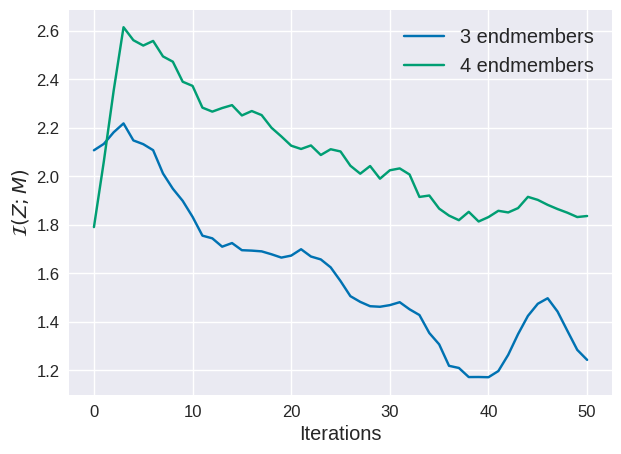

In [76]:
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5), constrained_layout=False)
    Ize_3end = Ize_3end_df['Ize'].to_numpy().reshape(1, -1)
    Ize_3end = moving_average(Ize_3end, n=5, padding_size=4).reshape(-1)
    Ize_4end = Ize_4end_df['Ize'].to_numpy().reshape(1, -1)
    Ize_4end = moving_average(Ize_4end, n=5, padding_size=4).reshape(-1)
    plt.plot(Ize_3end, label='3 endmembers')
    plt.plot(Ize_4end, label='4 endmembers')
    plt.xlabel('Iterations', fontsize='x-large')
    plt.ylabel('$\mathcal{I}(Z; M)$', fontsize='x-large')

plt.legend(fontsize='x-large')
# ticks to 'x-large'
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.show()

fig.savefig('Izm.pdf', bbox_inches='tight')